# Generative Advarsarial Network 

Here is presented the first GAN created by Ian Goodfellow https://arxiv.org/abs/1406.2661

Implementation is done in tensorflow

Created by: Tiago Almeida 02/02/2018

In [1]:
##imports
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import utils as ut # auxiliar file to help in data visualization

#tensorflow version when notebook was created - 1.4.0
tf.__version__


'1.4.0'

### Data MNIST

Extracting ./data\train-images-idx3-ubyte.gz
Extracting ./data\train-labels-idx1-ubyte.gz
Extracting ./data\t10k-images-idx3-ubyte.gz
Extracting ./data\t10k-labels-idx1-ubyte.gz


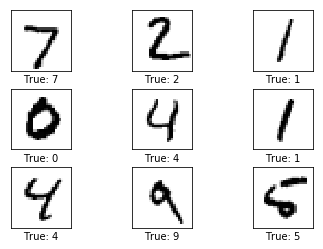

In [2]:
mnist_flat_size = 784

#mnist data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("./data")
ut.plot_mnist_images(mnist.test.images[0:9],cls_true=mnist.test.labels[0:9])

#reset graph using during notebook development
tf.reset_default_graph()



### Generator network 
In this implementation i use tensorflow layers API for creating the network

The network receive a 100-dimensinal vector (z) and return a 728-vector (same size of mnist image (28x28)). The objective is the generator create a mapping between space of vector z and the real MNIST DATA! (i think :P)

In [3]:
#array that contain the network dimention at least 2 dimention (input and output dimentions)
G_dimentions = [100,128,mnist_flat_size]

Z = tf.placeholder(tf.float32, shape=[None, G_dimentions[0]], name='x_generator_input')

def generator(x):
    '''
    Generator implemented as MLP
    
    :param x: tensor with shape (M,100) here M = number of samples
    :return: tensor with shape (M,728) corresponding to the image (28x28) mapping between x and data distribution (pData)
    '''
    with tf.name_scope("generator_nn"):
        g_net = tf.layers.dense(x,G_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='g_hidden1',reuse=tf.AUTO_REUSE)
        for i in range(2,len(G_dimentions)-1):#loop throw hidden layers
            g_net = tf.layers.dense(g_net,G_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='g_hidden'+str(i),reuse=tf.AUTO_REUSE)
        g_net = tf.layers.dense(g_net,G_dimentions[-1],activation=tf.nn.sigmoid,name='g_output',reuse=tf.AUTO_REUSE)
        return g_net


### Discriminator network 
In this implementation i use tensorflow layers API for creating the network

The network receives a image (728 vector) and try classify as fake or original.

In [4]:
#array that contain the network dimention at least 2 dimention (input and output dimentions)
D_dimentions = [mnist_flat_size,128,1] ##ouput 1-fake, 0-true

X = tf.placeholder(tf.float32, shape=[None, D_dimentions[0]], name='x_discriminator_input')

def discriminator(x):
    '''
    Discriminator implemented as MLP
    
    :param x: tensor with shape (M,728) here M = number of samples
    :return: tensor with shape (M,1) corresponding to the probability of each sample being true or fake
    '''
    with tf.name_scope("discriminator_nn"):
        d_net = tf.layers.dense(x,D_dimentions[1],
                                    activation=tf.nn.relu,
                                    name='d_hidden1',reuse=tf.AUTO_REUSE)
        for i in range(2,len(D_dimentions)-1):#loop throw hidden layers
            d_net = tf.layers.dense(d_net,D_dimentions[i],
                                    activation=tf.nn.relu,
                                    name='d_hidden'+str(i),reuse=tf.AUTO_REUSE)
        d_net = tf.layers.dense(d_net,D_dimentions[-1],activation=None,name='d_output',reuse=tf.AUTO_REUSE)
        #save the logits before the sigmoid activation (ouput between[0,1]) for alternative loss function
        d_logits = d_net
        d_net = tf.nn.sigmoid(d_net)
        return d_net,d_logits

### Loss functions Generator and Discriminator

Optimizers of tensorflow dont have maximizing method so we minimize the negative loss.

In [5]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_real, tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_fake, tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_fake, tf.ones_like(D_logit_fake)))

#this alternative loss use cross entropy (explanation why this makes senses TODO)
alternative_loss = True

with tf.name_scope("generator_loss"): #D(G(Z))
    generated_sample = generator(Z)
    d_fake_prob, d_fake_logits = discriminator(generated_sample)
    
    if alternative_loss:
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(d_fake_logits, tf.ones_like(d_fake_logits)))
    else:
        g_loss = -tf.reduce_mean(tf.log(d_fake_prob))

with tf.name_scope("discriminator_loss"):
    d_true_prob = discriminator(X)
    if alternative_loss:
        d_loss_true = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_real, tf.ones_like(D_logit_real)))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(D_logit_fake, tf.zeros_like(D_logit_fake)))
    else:
        d_loss = -tf.reduce_mean(tf.log(d_true_prob) + tf.log(1. - d_fake_prob))


#### Geting the trainable variables for generator and the discriminator (disadvantage of using layers API)

Since we dont want to obtimize the discriminator when training de generator and vice-versa

In [6]:
#
generator_variables = [var for var in tf.trainable_variables() if 'g_' in var.name]
discriminator_variables = [var for var in tf.trainable_variables() if 'd_' in var.name]

# kernel = weight
print(generator_variables)
print(discriminator_variables)



[<tf.Variable 'g_hidden1/kernel:0' shape=(100, 128) dtype=float32_ref>, <tf.Variable 'g_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'g_output/kernel:0' shape=(128, 784) dtype=float32_ref>, <tf.Variable 'g_output/bias:0' shape=(784,) dtype=float32_ref>]
[<tf.Variable 'd_hidden1/kernel:0' shape=(784, 128) dtype=float32_ref>, <tf.Variable 'd_hidden1/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'd_output/kernel:0' shape=(128, 1) dtype=float32_ref>, <tf.Variable 'd_output/bias:0' shape=(1,) dtype=float32_ref>]


### Training Algorithm


Epoach 0
Discriminator loss:  1.92747
Generator loss: 2.2636


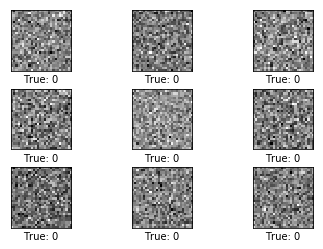

Epoach 1000
Discriminator loss:  0.0293978
Generator loss: 6.13019


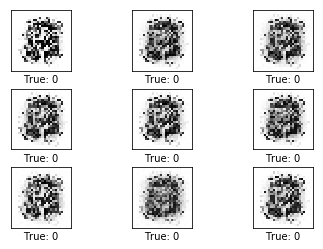

Epoach 2000
Discriminator loss:  0.0211299
Generator loss: 5.21317


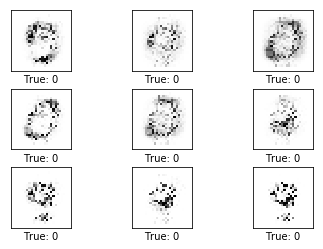

Epoach 3000
Discriminator loss:  0.153022
Generator loss: 5.23729


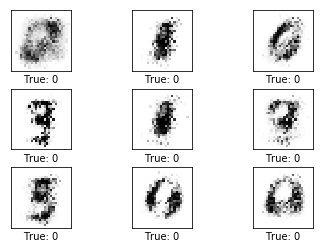

Epoach 4000
Discriminator loss:  0.204057
Generator loss: 5.71219


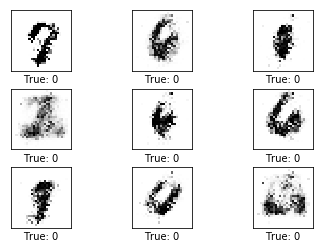

Epoach 5000
Discriminator loss:  0.226155
Generator loss: 5.98635


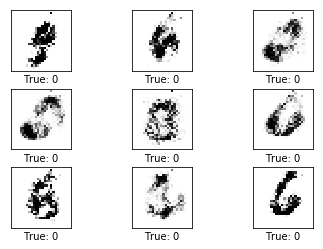

Epoach 6000
Discriminator loss:  0.42091
Generator loss: 4.73748


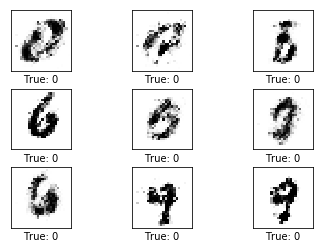

Epoach 7000
Discriminator loss:  0.43368
Generator loss: 3.32036


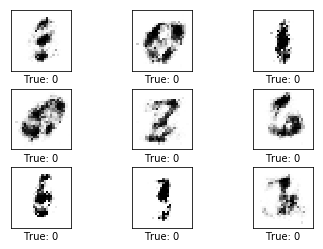

Epoach 8000
Discriminator loss:  0.66154
Generator loss: 3.79705


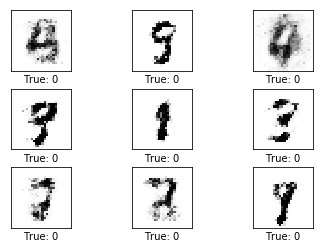

Epoach 9000
Discriminator loss:  0.323194
Generator loss: 3.00961


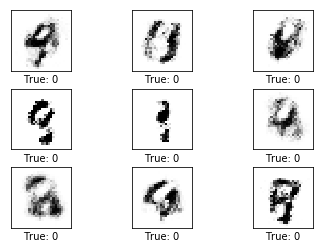

Epoach 10000
Discriminator loss:  0.498517
Generator loss: 2.64561


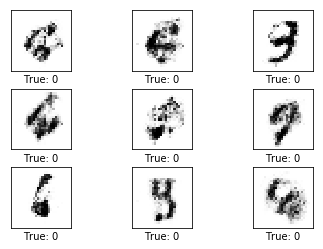

Epoach 11000
Discriminator loss:  0.856864
Generator loss: 2.43334


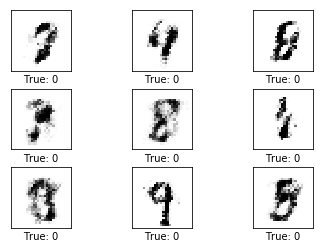

Epoach 12000
Discriminator loss:  0.658232
Generator loss: 2.39546


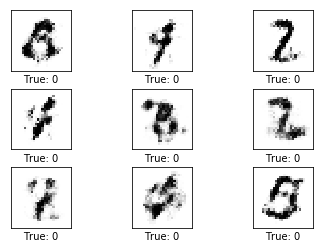

Epoach 13000
Discriminator loss:  0.617686
Generator loss: 2.47441


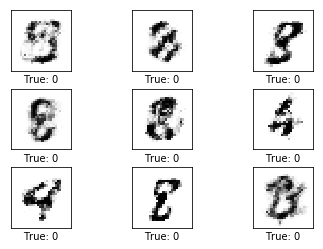

Epoach 14000
Discriminator loss:  1.02126
Generator loss: 1.58848


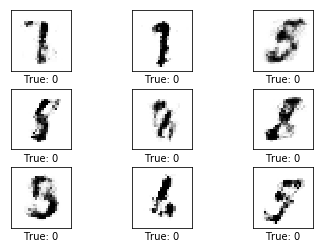

Epoach 15000
Discriminator loss:  0.629736
Generator loss: 2.77482


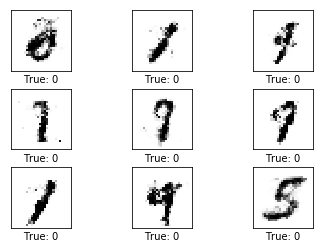

Epoach 16000
Discriminator loss:  0.800893
Generator loss: 2.27626


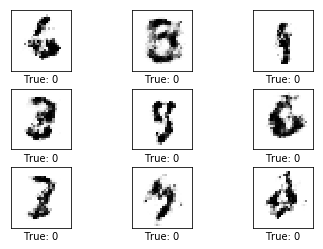

Epoach 17000
Discriminator loss:  0.959145
Generator loss: 2.0864


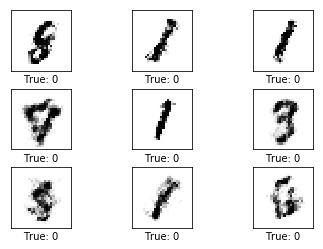

Epoach 18000
Discriminator loss:  0.747714
Generator loss: 2.0454


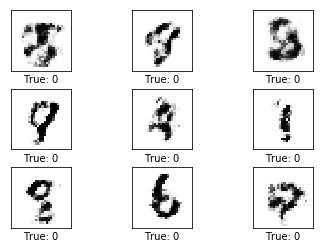

Epoach 19000
Discriminator loss:  0.892648
Generator loss: 1.82529


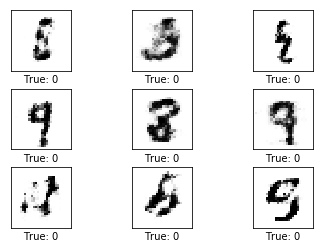

Epoach 20000
Discriminator loss:  0.826431
Generator loss: 2.01621


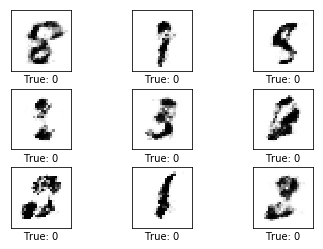

Epoach 21000
Discriminator loss:  0.959126
Generator loss: 1.88678


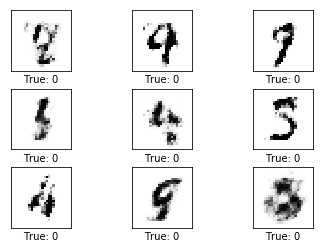

Epoach 22000
Discriminator loss:  0.687407
Generator loss: 1.8472


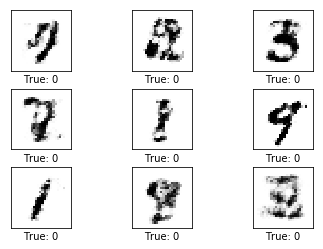

Epoach 23000
Discriminator loss:  0.664785
Generator loss: 1.6319


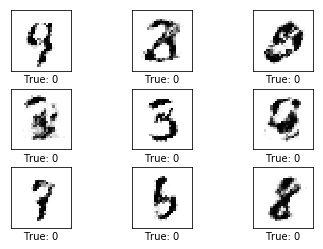

Epoach 24000
Discriminator loss:  0.768378
Generator loss: 2.09067


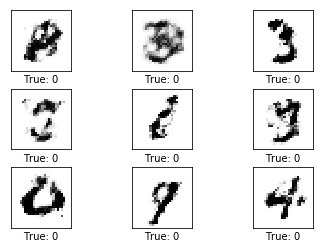

Epoach 25000
Discriminator loss:  0.736183
Generator loss: 2.04359


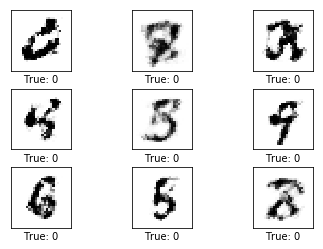

Epoach 26000
Discriminator loss:  0.91846
Generator loss: 2.11708


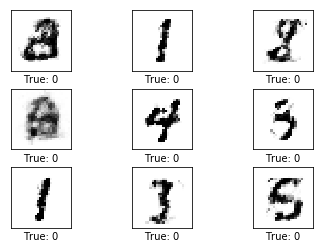

Epoach 27000
Discriminator loss:  0.765154
Generator loss: 1.84047


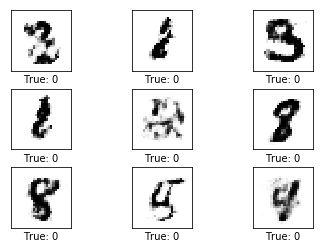

Epoach 28000
Discriminator loss:  0.763947
Generator loss: 1.8412


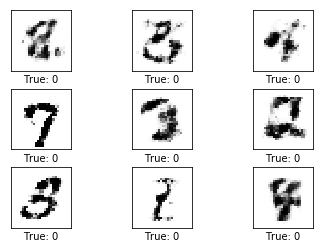

Epoach 29000
Discriminator loss:  0.870546
Generator loss: 1.88065


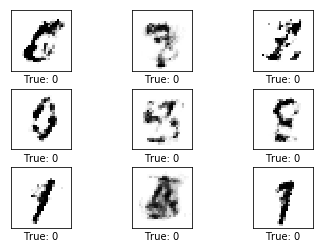

Epoach 30000
Discriminator loss:  0.85268
Generator loss: 1.88832


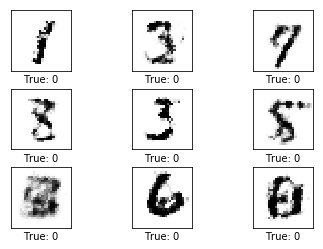

Epoach 31000
Discriminator loss:  0.860077
Generator loss: 2.30835


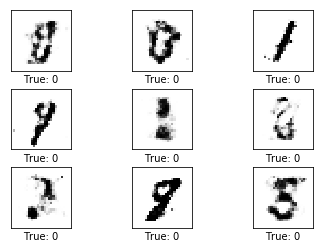

KeyboardInterrupt: 

In [7]:
lr=0.001
with tf.name_scope("discriminator_train"):
    d_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    d_train_op = d_optimizer.minimize(d_loss, var_list=discriminator_variables) # note minimizing negative loss is the same as maximizing, tf dont have maximizing

with tf.name_scope("generator_train"):
    g_optimizer = tf.train.AdamOptimizer(learning_rate=lr)
    g_train_op = g_optimizer.minimize(g_loss,var_list=generator_variables)


def random_Z(m, n=100):
    '''
    Random values for Z between -1 and 1
    
    :param m: number of samples
    :param n: dimension of Z
    :return: Vector with shape (m,n)
    '''
    return np.random.uniform(-1., 1., size=[m, n])

## Start graph computations and algorithm


batch_size = 100
epoach = 1000000

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(epoach):
    x_train,y_train = mnist.train.next_batch(batch_size)

    #first discriminator
    _, d_loss_value,d_sample = sess.run([d_train_op, d_loss, generated_sample], feed_dict={X: x_train, Z: random_Z(batch_size)})
    #second generator
    _, g_loss_value,g_sample = sess.run([g_train_op, g_loss,generated_sample], feed_dict={Z: random_Z(batch_size)})

    if i%1000 == 0:
        print("Epoach",i)
        print("Discriminator loss: ",d_loss_value)
        print("Generator loss:",g_loss_value)
        #print("D_sample",d_sample)
        #print("G_sample",g_sample)
        z_new = random_Z(9)

        generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})
        ut.plot_mnist_images(generated_images,cls_true=[0]*9)

##After the otimization lets generate some numbers :D 

z_new = random_Z(9)

generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})


#ut.plot_mnist_images(generated_images,cls_true=[0]*9)


In [ ]:


#generated_images = generated_sample.eval(session=sess,feed_dict={Z: z_new})
print(generated_images)
ut.plot_mnist_images(generated_images,cls_true=[0]*9)
